# Calculator-based validation of the MTPs
* rmses and crystal analysis
* currently waiting on lammps implementation of MTPs on Omega

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
from ase.io.extxyz import read_xyz
import numpy as np
from ase.atoms import Atoms
from ase.io.formats import index2range
from ase.io.cfg import read_cfg
from io import StringIO, UnsupportedOperation
from mtp import *
import os
from matplotlib import pyplot as plt
from quippy.potential import Potential
import pickle
from Ge_analysis import *
from Ge_calculation import *
import matplotlib.pyplot as plt
from matscipy.rings import ring_statistics
from datetime import datetime
import pymatgen.ext.matproj as mp
import pymatgen.io.ase as pase
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from numpy.random import normal
from ase.io.extxyz import write_xyz
from ase.io.lammpsdata import write_lammps_data

In [11]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [ 'Helvetica', 'Arial', 'FreeSans', 'DejaVu Sans' ]

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['legend.borderaxespad'] = 1.5

plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.5

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.0

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.0

plt.rcParams["figure.autolayout"] = False

# Labelling

In [4]:
GAP_18_dir = '/u/vld/hert5155/jup_remote/Ge_od/Si_GAP_training/libAtoms-silicon-testing-framework-fc252cb/models/GAP'
os.chdir('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP')
GAP_18_pot = Potential(param_filename=GAP_18_dir+'/gp_iter6_sparse9k.xml')

/u/vld/hert5155/ase/ase/calculators/calculator.py:507: FutureWarning: The keyword "ignore_bad_restart_file" is deprecated and will be removed in a future version of ASE.  Passing more than one positional argument to Calculator is also deprecated and will stop functioning in the future.  Please pass arguments by keyword (key=value) except optionally the "restart" keyword.
  warnings.warn(FutureWarning(


# Validation of indirect MTP
compare as far as possible to original tests on GAP-18 from paper
* ring stats
* structure factors
* vacancy formation energies

In [6]:
GAP_18_md = MD_run('/u/vld/hert5155/jup_remote/Ge_od/MD_runs/Si_litDB_full_4000/run_1000_001', label='GAP-18')

In [7]:

MTP_dir = '/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/MTPs/'
MTP_md_dir = '/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/MTP_mds/'

In [8]:
os.listdir(MTP_dir)

['u16_min1.5',
 'directMTP_u16m1.5.mtp',
 'directMTP_u20m1.5.mtp',
 'u16_m1.5_GAP18db.mtp',
 'u18_m1.5_GAP18db.mtp',
 'u20_m1.0_GAP18db.mtp',
 'u20_m1.5_GAP18db.mtp',
 'u20_min1.5_fw0.1_GAP18db.mtp',
 'u24_m1.5_GAP18db.mtp',
 'u26_m1.5_GAP18db.mtp']

In [ ]:

MTPs = [MTP(os.path.join(MTP_dir, 'u16_min1.5/GAP_18_db_GAPlabelled.mtp'), potential_name='MTP_u16_m1.5'),
        MTP(os.path.join(MTP_dir, 'u20_m1.5_GAP18db.mtp'), potential_name='MTP_u20_m1.5'),
        MTP(os.path.join(MTP_dir, 'directMTP_u16m1.5.mtp'), potential_name='DFT-MTP_u16_m1.5'),
        MTP(os.path.join(MTP_dir, 'directMTP_u20m1.5.mtp'), potential_name='DFT-MTPu20_m1.5')
        # MTP(os.path.join(MTP_dir, 'u16_min1.5/GAP_18_db_GAPlabelled.mtp'), potential_name='MTP u26_m1.5'),
        ]

calc_flag = [1, 1, 1, 1]

In [ ]:
os.listdir(MTP_md_dir)

In [ ]:
MTP_md = [MD_run(os.path.join(MTP_md_dir, i), label=i[:-9]) for i in os.listdir(MTP_md_dir)]

## RMSEs calculation

In [ ]:
db = myDB
# db = GAP_18_db
for j, M in enumerate(MTPs):
    print('Starting MTP {}'.format(j))
    if calc_flag[j]:
        for i, val in enumerate(db):

            M.calculate(val, properties=['energy', 'forces', 'stress'])
            # val.set_calculator(MTPs[0])
            # print(val.get_potential_energy())
            # print(MTPs[0].results)
            val.info['{}_energy'.format(M.name)] = M.results['energy']
            val.info['{}_virial'.format(M.name)] = M.results['stress']
            # if np.shape((MTPs[0].results['forces']))[1] != 3:
            #     print(i,val, len(i), MTPs[0].results['forces'])
            val.arrays['{}_force'.format(M.name)] = M.results['forces']
            val.set_calculator(None)
            M.results = {}

In [ ]:
GAP_18_db[0].arrays['gap18_force']
#sum([len(i) for i in GAP_18_db])*3
#np.average(flatten([i.get_atomic_numbers() for i in GAP_18_db]))

In [ ]:
# flattened data for DFT, GAP-18 and MTPs applied to the GAP-18 db
GAP_18_EF = [np.array([i.info['{}_energy'.format('gap18')]/len(i) for i in GAP_18_db]),
                  np.array(flatten([i.arrays['{}_force'.format('gap18')].flatten() for i in GAP_18_db]))]
                  #np.array(flatten([i.arrays['gap18_virial'].flatten() for i in GAP_18_db]))]
MTP_EF_GAP_18 = [[np.array([i.info['{}_energy'.format(j.name)]/len(i) for i in GAP_18_db]),
                  np.array(flatten([i.arrays['{}_force'.format(j.name)].flatten() for i in GAP_18_db]))]
                  #np.array(flatten([i.arrays['mtpu16_virial'].flatten() for i in GAP_18_db]))]
                  for j in MTPs]
GAP_18_DFT = [np.array([i.info['dft_energy']/len(i) for i in GAP_18_db]),
              np.array(flatten([i.arrays['dft_force'].flatten() for i in GAP_18_db]))
              #np.array(flatten([i.arrays['dft_virial'].flatten() for i in GAP_18_db]))
              ]

In [ ]:
# flattened data for DFT, GAP-18 and MTPs applied to myDB
GAP_18_EF_myDB = [np.array([i.info['{}_energy'.format('gap18')]/len(i) for i in myDB]),
                  np.array(flatten([i.arrays['{}_force'.format('gap18')].flatten() for i in myDB]))]
                  #np.array(flatten([i.arrays['gap18_virial'].flatten() for i in myDB]))]

MTP_EF_myDB = [[np.array([i.info['{}_energy'.format(j.name)]/len(i) for i in myDB]),
                  np.array(flatten([i.arrays['{}_force'.format(j.name)].flatten() for i in myDB]))]
                  #np.array(flatten([i.arrays['mtpu16_virial'].flatten() for i in myDB]))]
                  for j in MTPs]
myDB_DFT = [np.array([i.info['dft_energy']/len(i) for i in myDB]),
              np.array(flatten([i.arrays['dft_forces'].flatten() for i in myDB]))
              #np.array(flatten([i.arrays['dft_virial'].flatten() for i in myDB]))
              ]

In [ ]:
print(len(MTP_EF_GAP_18[0][1]))
len(GAP_18_DFT[1])

In [ ]:
# rmses for the GAP-18 db
rmses_MTP_DFT = [[rms_dict(i[j], GAP_18_DFT[j]) for j in range(len(GAP_18_DFT))] for i in MTP_EF_GAP_18]
rmses_MTP_GAP18 = [[rms_dict(i[j], GAP_18_EF[j]) for j in range(len(GAP_18_EF))] for i in MTP_EF_GAP_18]
rmses_GAP_DFT = [rms_dict(GAP_18_EF[j], GAP_18_DFT[j]) for j in range(len(GAP_18_DFT))]

In [ ]:
rmses_MTP_DFT

In [ ]:
rmses_MTP_GAP18

In [ ]:
rmses_GAP_DFT

In [ ]:
delX = [myDB[0].info['dft_energy'] - GAP_18_db[0].info['dft_energy'],
        0,
        0] # virial

In [ ]:
# rmses for myDB as validation set, need to adjust for different level of DFT (or just compare forces)
rmses_MTP_DFT_myDB = [[rms_dict(i[j], myDB_DFT[j] - delX[j]) for j in range(len(myDB_DFT))] for i in MTP_EF_myDB]
rmses_MTP_GAP18_myDB = [[rms_dict(i[j], GAP_18_EF_myDB[j]) for j in range(len(GAP_18_EF_myDB))] for i in MTP_EF_myDB]
rmses_GAP_DFT_myDB = [rms_dict(GAP_18_EF_myDB[j], myDB_DFT[j] - delX[j]) for j in range(len(myDB_DFT))]

In [ ]:
rmses_MTP_DFT_myDB

In [ ]:
rmses_MTP_GAP18_myDB

In [ ]:
rmses_GAP_DFT_myDB

## Plotting the RMSES
need to think about the best way to present this

In [ ]:
TS = [16, 20, 24]
# showing the RMSEs for different tensor sizes, compared to DFT, GAP-18 prediction and direct MTP

fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.05)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[:2]])*1000,
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP v. GAP-18 on GAP-18', zorder=5)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[2:]])*1000,
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18 on myDB', zorder=5)

axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18_myDB[:2]])*1000,
                yerr=None, fmt='^--', color='r', markersize=6, label='GAP-MTP v. GAP-18 on myDB', zorder=5)

axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18_myDB[2:]])*1000,
                yerr=None, fmt='^--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18 on myDB', zorder=5)
axs[0].set(xlabel='MTP setting', ylabel='Energy RMSE / meV')




axs[1].set(xlabel='MTP setting', ylabel='Force RMSE / $\mathrm{eV\AA^{-1}}$')

axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[:2]]),
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP on GAP-18_DB', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[2:]]),
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP on GAP-18_DB', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18_myDB[:2]]),
                yerr=None, fmt='^--', color='r', markersize=6, label='GAP-MTP on myDB', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18_myDB[2:]]),
                yerr=None, fmt='^--', color='Indigo', markersize=6, label='DFT-MTP on myDB', zorder=5)

axs[0].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[1].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[0].xaxis.labelpad = 7
axs[1].legend(title='all rms v. GAP-18 pot')
#axs[1].legend(bbox_to_anchor=(0.6,1.05))
# axs[1].xaxis.labelpad = 20

plt.tight_layout()
fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/rmse_vGAP18.png', dpi=100, bbox_inches='tight')

In [ ]:
print(rms_dict(MTP_EF_myDB[0][0], GAP_18_EF_myDB[0]))
rms_dict(GAP_18_EF_myDB[0], MTP_EF_myDB[1][0])


In [ ]:
fig, axs = plt.subplots()
axs.scatter(GAP_18_EF_myDB[0], MTP_EF_myDB[0][0], s=2, label='MTP-16', color='g', zorder=2)
axs.scatter(GAP_18_EF_myDB[0], MTP_EF_myDB[1][0], s=2, label='MTP-20', color='b')
# axs.plot(x:=np.linspace(-168.8,-168.0), x, color='k', linewidth=0.5)
axs.plot(x:=np.linspace(-163,-162.2), x, color='k', linewidth=0.5)
axs.set(xlim=(-163,-162.2), ylim=(-163,-162.2))
axs.legend(title='GAP-MTP v. GAP-18 on myDB', markerscale=3)
axs.set(xlabel='GAP-18 Energy  / $\mathrm{eV\AA^{-1}}$', ylabel='MTP prediction / $\mathrm{eV\AA^{-1}}$')
axs.tick_params(axis="both",direction="in", left="off",labelleft="on")
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.05)

# axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_GAP_DFT])*1000,
#                 yerr=None, fmt='o--', color='k', markersize=6, label='GAP-18 v. DFT', zorder=5)
#
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_DFT[:2]])*1000,
                yerr=None, fmt='o--', color='r', markersize=6, label='GAP-MTP v. DFT', zorder=5)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_DFT[2:]])*1000,
                yerr=None, fmt='o--', color='Indigo', markersize=6, label='DFT-MTP v. DFT')

axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[:2]])*1000,
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP v. GAP-18', zorder=5)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[2:]])*1000,
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18', zorder=5)


axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_DFT[:2]]),
                yerr=None, fmt='o--', color='r', markersize=6, label='GAP-MTP v. DFT', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_DFT[2:]]),
                yerr=None, fmt='o--', color='Indigo', markersize=6, label='DFT-MTP v. DFT')

axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[:2]]),
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP v. GAP-18', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[2:]]),
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18', zorder=5)


axs[0].set(xlabel='MTP setting', ylabel='Energy RMSE / meV')
axs[1].set(xlabel='MTP setting', ylabel='Force RMSE / $\mathrm{eV\AA^{-1}}$')
axs[0].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[1].tick_params(axis="both",direction="in", left="off",labelleft="on")
# axs[0].axhline(rmses_GAP_DFT[0]['rmse'],  color='k')
plt.tight_layout()
axs[1].legend(title='All on GAP-18 DB', bbox_to_anchor=(1.05,0.5))
# axs[1].xaxis.labelpad = 20
fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/rmse_vDFT.png', dpi=100, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.05)

In [ ]:
rs = [ring_statistics(i.df['Configs'][240000], cutoff=2.7) for i in MTP_md]
rs = pad_rstats(rs)

In [ ]:
rs_G18 = ring_statistics(GAP_18_md.df['Configs'][240000], cutoff=2.7)
rs_G18 = pad_rstats([rs_G18])

In [ ]:
rs_G18

In [ ]:
np.arange(2, len(rs_G18[0])), rs_G18[0][2:]

In [ ]:
order = [0, 2, 1, 3]
colors = ['darkred', 'red', 'darkblue', 'slateblue']
markers = ['x', '+', 'o', 's']
fig, axs = plt.subplots()
# colormap = plt.get_cmap('viridis')
# colors = [colormap(i) for i in np.linspace(F_reg[0], F_reg[-1], len(F_reg))]
for i, val in enumerate(order):
    axs.plot(np.arange(2, len(rs[0])), rs[val][2:], label=MTP_md[val].label,
    color=colors[i], marker=markers[i])
axs.plot(np.arange(2, len(rs_G18[0])), rs_G18[0][2:], label=GAP_18_md.label, marker='^', linestyle='--',
         color='k')
    # axs.set(xlim=(2,11), ylim=(-5,5))
axs.legend()
axs.set(xlabel='Ring size', ylabel='Count')
axs.tick_params(axis="both",direction="in", left="off",labelleft="on")
plt.tight_layout()
fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/rstat_4.png', dpi=100, bbox_inches='tight')

In [ ]:
for i in MTP_md:
    i.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='Sq_'+i.label,
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True)
    l_sel = [i for i in range(90)]
    a_sel = [i for i in range(90,110)]
    i.bin_fit(s_selection=l_sel, q_selection=[0.5,12], nbins=200)
    i.bin_fit(s_selection=a_sel, q_selection=[0.5,12], nbins=200)
    i.bin_bond_angle(s_selection=l_sel)
    i.bin_bond_angle(s_selection=a_sel)

In [ ]:
GAP_18_md.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                rings_dir='/u/vld/hert5155/jup_remote/Ge_od/MD_runs/Si_litDB_full_4000/Sq_rings_1000_001',
                opts={'Angles':True},
                rings_in={'species':['Si']},
                read_only=True)
l_sel = [i for i in range(90)]
a_sel = [i for i in range(90,110)]
GAP_18_md.bin_fit(s_selection=l_sel, q_selection=[0.5,12])
GAP_18_md.bin_fit(s_selection=a_sel, q_selection=[0.5,12])
GAP_18_md.bin_bond_angle(s_selection=l_sel)
GAP_18_md.bin_bond_angle(s_selection=a_sel)


In [ ]:
aSi_exp_Sq = np.genfromtxt('/u/vld/hert5155/jup_remote/Ge_od/paper_data/a-Si_x-ray_Laaziri1999.txt',
                          delimiter=', ').T

In [ ]:
linestyles = ['-', '--', '-.', ':']

In [ ]:
fig, axs = plt.subplots()
for ct, i in enumerate(order):
    axs.errorbar(*MTP_md[i].Sq_x_av[1], yerr=None,
                label=MTP_md[i].label, color=colors[ct], linestyle=linestyles[ct])

axs.errorbar(*GAP_18_md.Sq_x_av[1], yerr=None,
            label=GAP_18_md.label, color='k')
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=2, label='Exp. a-Si')
axs.legend(bbox_to_anchor=(1, 1.04), loc='upper right')
axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$\mathrm{S(Q)}$')
axs.set(xlim=(1.25,3), ylim=(0,1.9))
plt.tight_layout()

fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/amo_Sq_4_zoom.png', dpi=100, bbox_inches='tight')

In [ ]:
# BADFs
fig, axs = plt.subplots()
axs.plot(*GAP_18_md.bond_angle_av[0], color='k', linestyle='--')
axs.plot(*GAP_18_md.bond_angle_av[1], label=GAP_18_md.label, color='k')
for ct, i in enumerate(order):
    axs.errorbar(*MTP_md[i].bond_angle_av[0], yerr=None,
                 color=colors[ct])
    axs.errorbar(*MTP_md[i].bond_angle_av[1], yerr=None,
                label=MTP_md[i].label, color=colors[ct])

axs.legend(title='- amo\n-- liquid')
axs.set(xlabel='Angle / deg', ylabel='')
fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/BADF_4.png', dpi=100, bbox_inches='tight')

## Bimodality of GAP-predicted errors

In [35]:
gldir = '/home/tridymite/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/rmses/gap_local_var/'

In [15]:
with open('/home/tridymite/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/rmses/gap_local_var/LOCAL_E_traj_compress_GAP-18_ALL_frame_200_relabel_SOAP.xyz', 'r') as f:
    VLDg18_ff = list(read_xyz(f))[0]

In [36]:
from os.path import join
with open(join(gldir, 'run_100k_u16_fw0.1_PQ1k_G18_scratch_indirect_relabel_SOAP_B_finalframe_GAPLV.xyz'), 'r') as f:
    PQ1k_rand_16 = list(read_xyz(f))[0]

In [62]:
with open(join(gldir, 'run_100k_u16_m1.5_fw0.1_PQ1k-1_amo_G18_scratch_relabel_SOAP_B_ff.xyz'), 'r') as f:
    PQ1k_amo_16 = list(read_xyz(f))[0]

In [60]:
with open(join(gldir, 'run_100k_u16_fw0.1_indirect_ff.xyz'), 'r') as f:
    u16_g18db = list(read_xyz(f))[0]

In [81]:
import scipy as sci

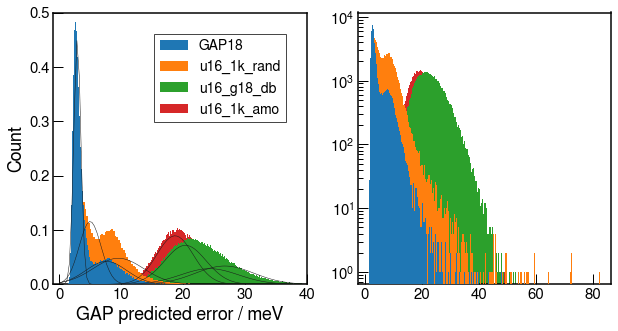

In [104]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
dat = [VLDg18_ff, PQ1k_rand_16, u16_g18db, PQ1k_amo_16]
labels = ['GAP18', 'u16_1k_rand', 'u16_g18_db', 'u16_1k_amo']

for i, val in enumerate(dat):
    axs.hist(np.sqrt(val.arrays['GAP18_variance'])*1000, bins=300, label=labels[i], zorder=len(dat)-i, density=True)
    axs2.hist(np.sqrt(val.arrays['GAP18_variance'])*1000, bins=300, label=labels[i], zorder=len(dat)-i)
    mixture = GaussianMixture(n_components=2).fit(1000*np.sqrt(val.arrays['GAP18_variance']).reshape(-1, 1))
    means_hat = mixture.means_.flatten()
    weights_hat = mixture.weights_.flatten()
    sds_hat = np.sqrt(mixture.covariances_).flatten()
#     axs.plot(x := np.linspace(0,40,100), sum([weights_hat[i]*sci.stats.norm(means_hat[i],sds_hat[i]).pdf(x)
#                                               for i in range(len(means_hat))]), zorder=10, color='k')
    vals = [weights_hat[i]*sci.stats.norm(means_hat[i],sds_hat[i]).pdf(x)
                                               for i in range(len(means_hat))]
    for i in vals:
        axs.plot(x := np.linspace(0,40,100), i, zorder=10, color='k', linewidth=0.5)

axs2.set_yscale('log')
axs.set(ylim=(0,0.5), xlim=(-1,40), xlabel='GAP predicted error / meV', ylabel='Count')
# axs2.set(ylim=(0,4000))
axs.legend()

In [79]:
sns.reset_orig()

In [73]:
from sklearn.mixture import GaussianMixture
mixture = GaussianMixture(n_components=2).fit(1000*np.sqrt(VLDg18_ff.arrays['GAP18_variance']).reshape(-1, 1))
means_hat = mixture.means_.flatten()
weights_hat = mixture.weights_.flatten()
sds_hat = np.sqrt(mixture.covariances_).flatten()

print(mixture.converged_)
print(means_hat)
print(sds_hat)
print(weights_hat)

True
[2.89544178 7.58321844]
[0.57602462 3.29917887]
[0.65160578 0.34839422]
